In [430]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import scipy
import pickle
from scipy.stats import poisson
import pymc as pm

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [424]:
# First load the data 

cmap = 'afmhot'

hdulist1 = fits.open('/Users/jmartine/science/data/clusters_morales/images/00360-K.fits')
hdulist2 = fits.open('/Users/jmartine/science/data/clusters_morales/images/00360-I4.fits')

#bkg = 6.0

im_K = hdulist1[0].data
im_I1 = np.array(hdulist2[0].data[4:15,3:14])
im_I1 = im_I1[::-1,:]

print np.min(im_I1)

im_I1[im_I1 < 0.0] = 0.0

108.297


In [445]:
# Read data of observed clusters (from Esteban Morales)
hdulist = fits.open('/Users/jmartine/science/data/clusters_morales/r08-objects.fits')
tbdata = hdulist[1].data

hdulist = fits.open('/Users/jmartine/science/data/clusters_morales/ukidss-sources.fits')
tbdata1 = hdulist[1].data

id = 360  # ID of the source
ind_id1 = where(tbdata1['r08_id'] == id)

print tbdata1['ra'][ind_id1],tbdata1['dec'][ind_id1]

#print tbdata['recno']

[ 267.20221338  267.2022071 ] [-28.01995396 -28.01980608]


Filename: /Users/jmartine/science/data/clusters_morales/psfs/irac4-glimpse.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       9   (279, 279)   float32   


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  279 / length of data axis 1                          
NAXIS2  =                  279 / length of data axis 2                          
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
PRFSAMPX=                    5                                                  
PRFSAMPY=                    5                                                  

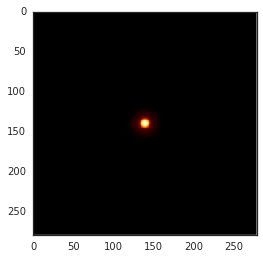

In [426]:
# PSFs

psf_I1 = fits.open('/Users/jmartine/science/data/clusters_morales/psfs/irac4-glimpse.fits')
psf_I1_data = psf_I1[0].data
plt.imshow(psf_I1_data, interpolation='None',cmap=cmap)

psf_I1.info()
psf_I1[0].header

(20, 35)

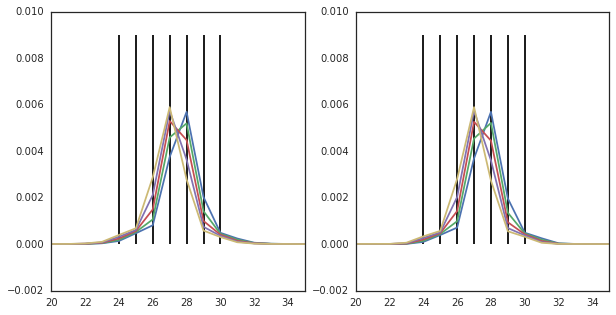

In [427]:
plt.subplots(1,2,figsize=(10,5))
plt.subplot(1,2,1)
for i in arange(5): plt.plot(psf_I1_data[139,i::5])
for j in arange(24,31): vlines(j,0,0.009)
plt.xlim(20,35)
plt.subplot(1,2,2)
for i in arange(5): plt.plot(psf_I1_data[i::5,139])
for j in arange(24,31): vlines(j,0,0.009)
plt.xlim(20,35)
#plt.plot(psf_I1_data[139,:])
#vlines(139.,0,0.009)

plt.xlim(20,35)

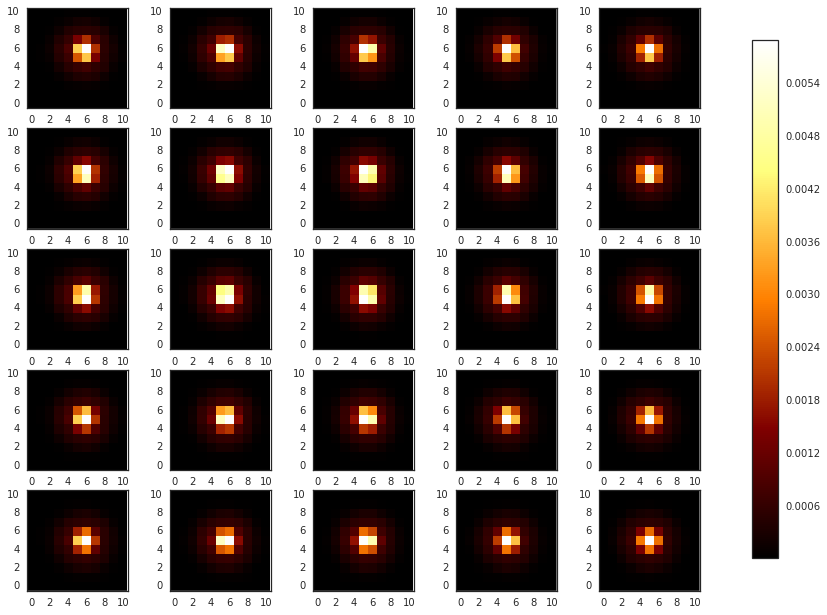

In [428]:
fig, axes = plt.subplots(nrows=5, ncols=5)
fig.set_size_inches(12, 9)
# Plot kernels
for i in range(5):
    for j in range(5):
        #prf_image = prf_discrete._prf_array[i, j]
        im = axes[i, j].imshow(psf_I1_data[i::5,j::5][22:33,22:33], interpolation='None',origin='lower',cmap=cmap,)
        #ax = plt.gca()
        #ax.invert_yaxis()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
plt.colorbar(im, cax=cax)
plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05)



#plt.subplots(1,5,figsize=(10,5))
#plt.subplot(1,2,1)
#CT1 = plt.imshow(psf_I1_data[0::5,0::5][23:34,23:34], interpolation='None',origin='lower',cmap=cmap,)
#CC1 = plt.colorbar(CT1, shrink=0.8, extend='both')
#plt.subplot(1,2,2)
#CT2 = plt.imshow(psf_I1_data[1::5,1::5][23:34,23:34], interpolation='None',origin='lower',cmap=cmap,)
#CC2 = plt.colorbar(CT2, shrink=0.8, extend='both')

In [429]:
id = 360  # ID of the source
ind_id1 = where(tbdata1['r08_id'] == id)

print tbdata1['id'][ind_id1]
print tbdata1['rmean_q'][ind_id1]
print tbdata1['match'][ind_id1]

#tbdata1['rmean_q']

[5000023 5000020]
[ 1.09534705  1.07552099]
[ True  True]


In [395]:
# Parameters of the Gaussians
centers = np.array([[9.3298737-4,15-8.8453822],[8.9493801-4,15-9.0742081],[9.6347642-4,15-6.2206327]])
#centers = np.array([[8.8992286-4,15-8.6491883],[9.7847493-4,15-9.305231]])
#sigma = [[[0.36,0],[0,0.36]],[[0.36,0],[0,0.36]],[[0.36,0],[0,0.36]]]
#sigma = [[0.36,0],[0,0.36]]
#tau = np.linalg.inv(sigma)

#print int(math.modf(centers[0,0])[0])
print centers[1,1]
print int(100.0*math.modf(centers[1,1])[0]/20.0)

5.9257919
4


108.297 4200.22


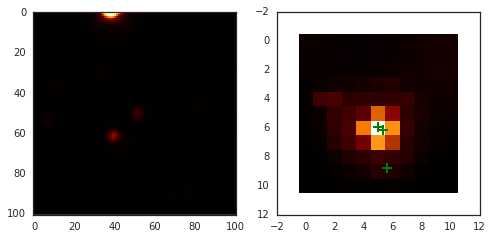

In [396]:
cmap = 'afmhot'
plt.subplots(1,2,figsize=(8,12))
plt.subplot(1,2,1)
plt.imshow(im_K, interpolation='None',cmap=cmap)
plt.subplot(1,2,2)
mini = np.min(im_I1)
maxi = np.max(im_I1)
plt.imshow(im_I1, interpolation='None',vmin=mini,vmax=maxi,cmap=cmap)
#plt.plot(7.118655-0.5,11-(5.5868723),marker='+',color='red',ms=10,mew=2)
#for i in arange(len(centers)): plt.plot(centers[i][0],centers[i][1],marker='+',color='green',ms=10,mew=2)
for i in arange(len(centers)): plt.plot(centers[i][0],centers[i][1],marker='+',color='green',ms=10,mew=2)
    

print mini,maxi

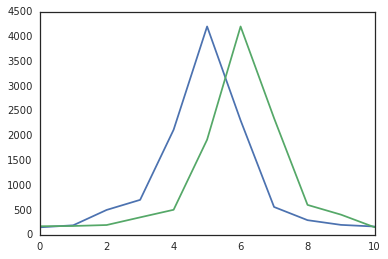

In [397]:
plt.plot(im_I1[6,:])
#plt.plot(im_I1[6,:])
plt.plot(im_I1[:,5])
#plt.plot(im_I1[:,6])

In [398]:
# Number of pixels
M = im_I1.size

#print len(im_I1[:,0])

# Width of the grid element
w = 1.0

# Array of coordinates
X = []
counts = []

for i in arange(len(im_I1[:,0])):
    for j in arange(len(im_I1[0,:])):
        X.append([i,j])
        counts.append(im_I1[i,j])

X =  np.array(X)
counts = np.array(counts)


# The measured values are the fluxes in each pixel. In the Chicago example, this corresponds to counts.

#for i in arange(len(X)): print X[i],counts[i]


(121,)
0.988855322242


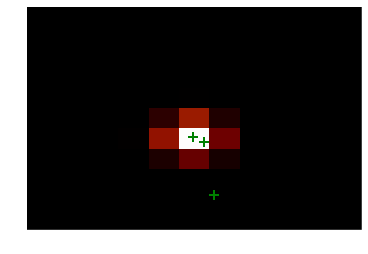

In [449]:
# With Gaussian PSF

mixture0 = []
mixture1 = []
mixture2 = []
#mixture3 = []
#mixture4 = []
#mixture5 = []


for i in range(0,M):
    mixture0.append(np.exp(-0.5*transpose(X[i]-centers[0]).dot(tau).dot(X[i]-centers[0])))
    mixture1.append(np.exp(-0.5*transpose(X[i]-centers[1]).dot(tau).dot(X[i]-centers[1])))
    mixture2.append(np.exp(-0.5*transpose(X[i]-centers[2]).dot(tau).dot(X[i]-centers[2])))
    #mixture3.append(np.exp(-0.5*transpose(X[i]-centers[3]).dot(tau).dot(X[i]-centers[3])))
    #mixture4.append(np.exp(-0.5*transpose(X[i]-centers[4]).dot(tau).dot(X[i]-centers[4])))
    #mixture5.append(np.exp(-0.5*transpose(X[i]-centers[5]).dot(tau).dot(X[i]-centers[5])))
    

mixture0 = np.array(mixture0)
mixture1 = np.array(mixture1)
mixture2 = np.array(mixture2)
#mixture3 = np.array(mixture3)
#mixture4 = np.array(mixture4)
#mixture5 = np.array(mixture5)

print shape(mixture0)


bot0 = np.reshape(mixture0,(11,11))
bot1 = np.reshape(mixture1,(11,11))
bot2 = np.reshape(mixture2,(11,11))
#bot3 = np.reshape(mixture3,(11,11))
#bot4 = np.reshape(mixture4,(11,11))
#bot5 = np.reshape(mixture5,(11,11))

#bot = (10.0**2.35)*bot0+(10.0**2.0)*bot1+(10.0**(-0.9))*bot2+(10.0**2.11)*bot3+(10.0**0.4)*bot4 #+(10.0**0.4)*bot5
bot = (10.0**0.0)*bot1

print np.max(bot)

plt.imshow(bot.T,interpolation='None',cmap=cmap)
plt.axis('tight')
plt.axis('off')
for i in arange(len(centers)): plt.plot(centers[i][0],centers[i][1],marker='+',color='green',ms=10,mew=2)


[[ 5.3298737  6.1546178]
 [ 4.9493801  5.9257919]
 [ 5.6347642  8.7793673]]
3
2
4
4
0
0


/Users/jmartine/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


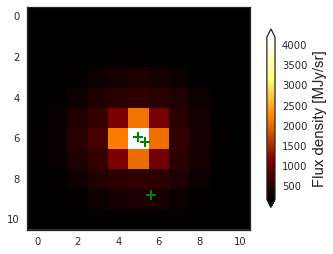

In [453]:
# With actual Spitzer PRF
print centers

#image_all = np.zeros((11,11))
image_all = []

for i in arange(0,len(centers)):
    ycoord = 4-int(100.0*math.modf(centers[i,0])[0]/20.0)-1
    if (ycoord == -1): ycoord = 4
    if (ycoord == 5): ycoord = 0    
    xcoord = 4-int(100.0*math.modf(centers[i,1])[0]/20.0)-1
    if (xcoord == -1): xcoord = 4
    if (xcoord == 5): xcoord = 0
    print xcoord
    print ycoord
    

    #xcoord_cent = np.where(psf_I1_data[xcoord::5,ycoord::5] == np.max(psf_I1_data[xcoord::5,ycoord::5]))[0][0]
    #ycoord_cent = np.where(psf_I1_data[xcoord::5,ycoord::5] == np.max(psf_I1_data[xcoord::5,ycoord::5]))[1][0]

       
    image_all.append(psf_I1_data[xcoord::5,ycoord::5][17+centers[i,0]:28+centers[i,0],17+centers[i,1]:28+centers[i,1]])

CS1 = plt.imshow(10.0**2.0*image_all[0]+10.0**5.835*image_all[1]+10.0**4.25*image_all[2]+170.0,interpolation='None',cmap=cmap)
plt.axis('tight')
plt.axes().set_aspect('equal')
#CS1 = plt.imshow(10.0**5.0*image_all[0]+53.2,interpolation='None',cmap=cmap)
CB1 = plt.colorbar(CS1, shrink=0.8, extend='both')
CB1.set_label('Flux density [MJy/sr]',size=15)
#plt.imshow(image_all[0],interpolation='None',cmap=cmap)

for i in arange(len(centers)): plt.plot(centers[i][0],centers[i][1],marker='+',color='green',ms=10,mew=2)

In [410]:
# priors must be on the paramters of the Gaussians

import pymc as pm

A0 = pm.Uniform(name='A0', lower=2.0, upper=6.0)
A1 = pm.Uniform(name='A1', lower=2.0, upper=6.0)
A2 = pm.Uniform(name='A2', lower=2.0, upper=6.0)
#A3 = pm.Uniform(name='A3', lower=1.0, upper=6.0)
#A4 = pm.Uniform(name='A4', lower=1.0, upper=6.0)
bkg = pm.Uniform(name='bkg', lower=100.0, upper=200.0)
offset_x = pm.Uniform(name='offset_x',lower=-1,upper=1)
offset_y = pm.Uniform(name='offset_y',lower=-1,upper=1)

@pm.deterministic
def lambdas(A0 = A0, A1 = A1, A2 = A2, bkg = bkg, offset_x = offset_x, offset_y = offset_y, w = 1.0):
    
    image_all = []
    
    for i in arange(0,len(centers)):
        ycoord = int(round(4-int(100.0*math.modf(centers[i,0])[0]/20.0)+offset_y))
        if (ycoord == -1): ycoord = 4
        if (ycoord == 5): ycoord = 0    
        xcoord = int(round(4-int(100.0*math.modf(centers[i,1])[0]/20.0)+offset_x))
        if (xcoord == -1): xcoord = 4
        if (xcoord == 5): xcoord = 0
            
        image_all.append(psf_I1_data[xcoord::5,ycoord::5][17+centers[i,0]:28+centers[i,0],17+centers[i,1]:28+centers[i,1]])
    
    
    return ((10.0**A0)*image_all[0].T+(10.0**A1)*image_all[1].T+(10.0**A2)*image_all[2].T+bkg)*(w**2)
    #return ((10.0**A2)*image_all[2].T+bkg)*(w**2)
    
likelihood = pm.Poisson(name='likelihood', mu=lambdas, value=counts, observed=True)    

/Users/jmartine/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [19]:
# priors must be on the paramters of the Gaussians

import pymc as pm

A0 = pm.Uniform(name='A0', lower=log10(0.01), upper=log10(1000))
A1 = pm.Uniform(name='A1', lower=log10(0.01), upper=log10(1000))
A2 = pm.Uniform(name='A2', lower=log10(0.01), upper=log10(1000))
#A3 = pm.Uniform(name='A3', lower=log10(0.01), upper=log10(1000))
#A4 = pm.Uniform(name='A4', lower=log10(0.01), upper=log10(1000))
#A5 = pm.Uniform(name='A5', lower=log10(0.01), upper=log10(1000))
#off_x = pm.Normal('off_x',mu=0.0,tau=1./0.3)
#off_y = pm.Normal('off_y',mu=0.0,tau=1./0.3)
#off_x = pm.Uniform(name='off_x', lower=-0.5, upper=0.)
#off_y = pm.Uniform(name='off_y', lower=-0.5, upper=0.)
pos_unc = 0.3
r = pm.Uniform(name='r', lower=0, upper=pos_unc)
theta = pm.Uniform(name='theta',lower=0,upper=2*pi)
bkg = pm.Uniform(name='bkg', lower=0.0, upper=10.0)

#D = pm.MvNormal(name='MVN0', mu=mu[0], tau=tau[0]) + pm.MvNormal(name='MVN1', mu=mu[1], tau=tau[1]) +\
#pm.MvNormal(name='MVN2', mu=mu[2], tau=tau[2])

@pm.deterministic
def lambdas(A0 = A0, A1 = A1, A2 = A2, bkg = bkg, r = r, theta = theta, w=1.0):
    
    mixture0 = []
    mixture1 = []
    mixture2 = []
    
    off_vector = [pos_unc + r * math.cos(theta), pos_unc + r * math.sin(theta)]

    for i in range(0,M):
        mixture0.append(bkg + np.exp(-0.5*transpose(X[i]-(centers[0]+off_vector)).dot(tau).dot(X[i]-(centers[0]+off_vector))))
        mixture1.append(bkg + np.exp(-0.5*transpose(X[i]-(centers[1]+off_vector)).dot(tau).dot(X[i]-(centers[1]+off_vector))))
        mixture2.append(bkg + np.exp(-0.5*transpose(X[i]-(centers[2]+off_vector)).dot(tau).dot(X[i]-(centers[2]+off_vector))))
        

    mixture0 = np.array(mixture0)
    mixture1 = np.array(mixture1)
    mixture2 = np.array(mixture2)
    
    bot0 = np.reshape(mixture0,(11,11))
    bot1 = np.reshape(mixture1,(11,11))
    bot2 = np.reshape(mixture2,(11,11))

    return ((10.0**A0)*bot0+(10.0**A1)*bot1+(10.0**A2)*bot2)*(w**2)

likelihood = pm.Poisson(name='likelihood', mu=lambdas, value=counts, observed=True)


In [411]:
m = pm.Model([A0, A1, A2, bkg, offset_x, offset_y, lambdas, likelihood])
mc = pm.MCMC(m, db='pickle', dbname='ID_360_model_I4.pickle')
#mc = pm.MCMC(m)
mc.sample(iter=200000, burn=40000)
mc.db
mc.db.close()

 [-----------------100%-----------------] 200000 of 200000 complete in 138.1 sec

/Users/jmartine/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [412]:
db = pm.database.pickle.load('ID_360_model_I4.pickle')

(array([  1.20000000e+01,   4.00000000e+00,   9.60000000e+01,
          3.43000000e+02,   1.18800000e+03,   3.06300000e+03,
          6.75200000e+03,   1.28240000e+04,   1.85000000e+04,
          2.50310000e+04,   2.64400000e+04,   2.48920000e+04,
          1.77490000e+04,   1.20500000e+04,   6.52300000e+03,
          3.03800000e+03,   1.06200000e+03,   3.27000000e+02,
          8.70000000e+01,   1.90000000e+01]),
 array([ 162.89706454,  163.55359588,  164.21012722,  164.86665856,
         165.52318991,  166.17972125,  166.83625259,  167.49278393,
         168.14931527,  168.80584662,  169.46237796,  170.1189093 ,
         170.77544064,  171.43197198,  172.08850332,  172.74503467,
         173.40156601,  174.05809735,  174.71462869,  175.37116003,
         176.02769137]),
 <a list of 20 Patch objects>)

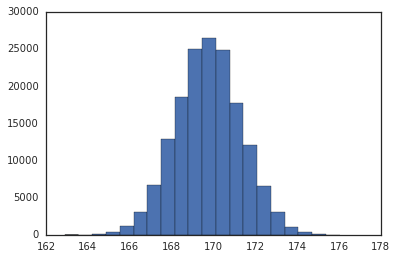

In [421]:
#fig = plt.figure(figsize=(16,8))
#pm.Matplot.plot(A0, new=False)
#plt.savefig('posterior.ps')

plt.hist(db.trace('bkg')[:],bins=20)
#plt.plot(db.autocorr('A1'))

#pm.Matplot.autocorrelation(db.trace('A1')[:],db.trace('A1')[:])

In [417]:
import seaborn as sns
sns.set_style("white")
def plot_counts(counts):
    cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
    #colors = counts / np.double(np.max(counts))
    colors = counts
    print shape(colors)
    #plt.contour(colors)
    #CS = plt.scatter(X[:,0], X[:,1], s=250, c=colors, cmap='YlOrRd', edgecolors='none')
    colors = reshape(colors,(11,11),'F')
    colors = colors.T
    plt.subplots(1,2,figsize=(12,5))
    plt.subplot(1,2,1)
    for i in arange(len(centers)): plt.plot(centers[i][0],centers[i][1],marker='+',color='red',ms=10,mew=2)
    CS = plt.imshow(colors,interpolation='None',cmap=cmap)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    CB.set_label('Flux density [MJy/sr]',size=15)
    plt.xlabel('x [pixels]',size=15)
    plt.ylabel('y [pixels]',size=15)
    #plt.xlabel('RA',size=20)
    #plt.ylabel('Dec',size=20)
    plt.title('Simulated image',size=20)
    plt.text(0.0,1,'ID 360',size=15,color='white')
    plt.text(5.9,9,'1 pixel = 1.2"',size=15,color='white')
    plt.text(3.5,10,'IRAC4, FWHM = 2.0"',size=15,color='white')
    plt.subplot(1,2,2)
    for i in arange(len(centers)): plt.plot(centers[i][0],centers[i][1],marker='+',color='red',ms=10,mew=2)
    CS1 = plt.imshow(im_I1, interpolation='None',cmap=cmap)
    CB1 = plt.colorbar(CS1, shrink=0.8, extend='both')
    CB1.set_label('Flux density [MJy/sr]',size=15)
    plt.xlabel('x [pixels]',size=15)
    plt.ylabel('y [pixels]',size=15)
    plt.title('Measured image',size=20)
    plt.text(0.0,1,'ID 360',size=15,color='white')
    plt.text(5.9,9,'1 pixel = 1.2"',size=15,color='white')
    plt.text(3.5,10,'IRAC4, FWHM = 2.0"',size=15,color='white')
    #plt.subplot(2,2,3)
    #plt.plot(colors.T[5,:])
    #plt.plot(colors.T[4,:])
    #plt.plot(colors.T[:,5])
    #plt.plot(colors.T[:,4])
    #plt.subplot(2,2,4)
    #plt.plot(im_I1[5,:])
    #plt.plot(im_I1[4,:])
    #plt.plot(im_I1[:,5])
    #plt.plot(im_I1[:,4])
    plt.savefig('posterior_image_360_I4.png',dpi=300,bbox_inches='tight')
    plt.savefig('posterior_image_360_I4.ps',dpi=300,bbox_inches='tight')
    plt.savefig('posterior_image_360_I4.pdf',dpi=300,bbox_inches='tight')

(11, 11)


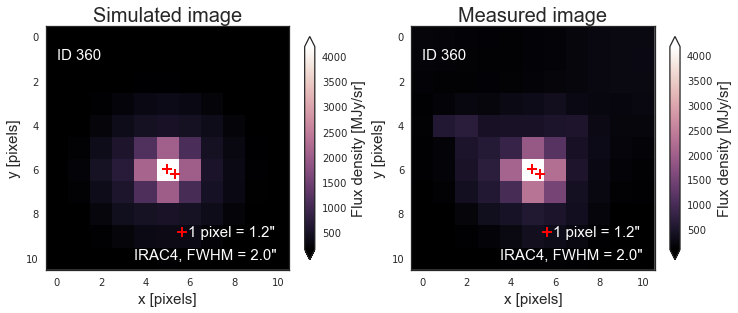

In [418]:
posterior_pymc = np.mean(db.trace('lambdas')[:], axis=0)
plot_counts(posterior_pymc)


(19, 35)

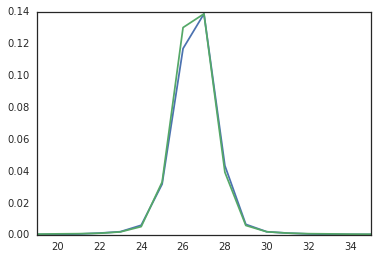

In [100]:
#plt.plot(binim[26,:])
plt.plot(binned_data_psf[27,:])
#plt.plot(binim[28,:])

#plt.plot(binim[:,26])
plt.plot(binned_data_psf[:,27])
#plt.plot(binim[:,28])

plt.xlim(19,35)

In [90]:
# resize for 3x3 by getting rid of extra columns/rows
xedge = np.shape(psf_I1_data)[0]%5
yedge = np.shape(psf_I1_data)[1]%5
im = psf_I1_data[xedge:,yedge:]

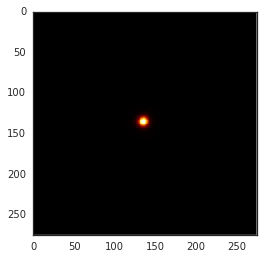

In [91]:
plt.imshow(im,interpolation='None',cmap=cmap)

In [77]:
# put image array into arrays of 3x3
binim = np.reshape(im,(np.shape(im)[0]/5,5,np.shape(im)[1]/5,5)) 

In [78]:
# average each 3x3 array
binim = np.mean(binim,axis=3)
binim = np.mean(binim,axis=1)

In [79]:
print shape(binim)

(55, 55)


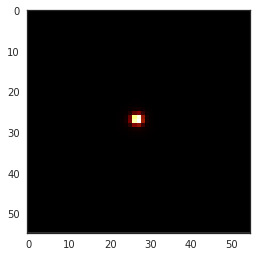

In [80]:
plt.imshow(binim,interpolation='None',cmap=cmap)

(21, 33)

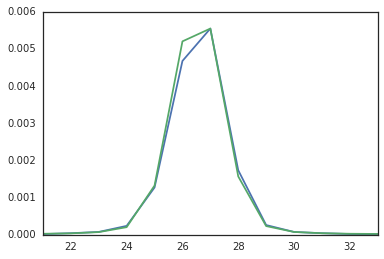

In [81]:
#plt.plot(binim[26,:])
plt.plot(binim[27,:])
#plt.plot(binim[28,:])

#plt.plot(binim[:,26])
plt.plot(binim[:,27])
#plt.plot(binim[:,28])

plt.xlim(21,33)

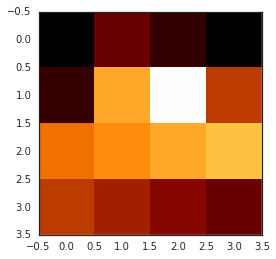

In [322]:
prob = np.array([[2,6,4,2],[4,13,21,9],[11,12,13,14],[9,8,7,6]])
plt.imshow(prob,interpolation='None',cmap=cmap)

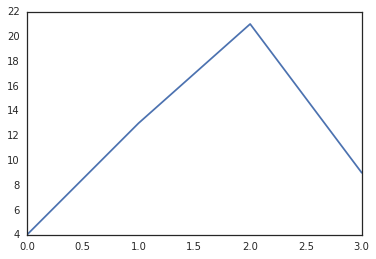

In [324]:
plt.plot(prob[1,:])